In [1]:
from pyfreefem import FreeFemRunner, readFFArray
from nullspace_optimizer import Optimizable, nlspace_solve
from pymedit import Mesh, P1Function, trunc, Mesh3D, cube, mmg3d, generate3DMesh, P1Function3D, trunc3DMesh
from pymedit import saveToVtk, advect, P1Vector3D, mshdist
import numpy as np
import shutil
import pandas as pd

output='output/caseCylinderTest1' #1
import os
os.makedirs(output,exist_ok=True)

config={'OUTPUT':output}

N=8 #number of cores
i = format(0,'04d')
meshes='meshes'
M0 = Mesh3D(meshes+"/CylinderOrdered.mesh")
Th0 = mmg3d(M0,extra_args='-nomove -noswap -nosurf -noinsert',nr=False)
#Th0=M0

epsB = 0.05 #NO CAMBIAR, ES EL QUE USO PARA NAVIER STOKES Y GEOMETRÍA!
eps = 0.01 #SE PUEDE CAMBIAR, ES EL EPSILON PARA LA BARRERA
r=0.1
R=0.2

barrier = lambda x,y,z: (z-0.5)**2 + (y-0.5)**2 - 0.11**2
phi1 = lambda x,y,z: (z-0.5)**2 + (y-0.5)**2 - 0.1**2
phi2 = lambda x,y,z: (z-0.5)**2 + (y-0.5)**2 - 0.3**2

# Meshing parameters
hmin = 1e-2
hmax = 5e-2
hgrad = 1.3 # Gradation factor
hausd = 1e-3 # Approximation quality factor, leave as it is

# Local parameter to prescribe local mesh size on the interface boundary (corresponding to the level set)
paramsmmg = f"""Parameters
5

10 Triangles 1e-2 2.5e-2 1e-3
1 Triangles 1e-2 2.5e-2 1e-3
2 Triangles 1e-2 2.5e-2 1e-3
3 Triangles 1e-2 2.5e-2 1e-3
4 Triangles 1e-2 2.5e-2 1e-3
"""

phiinit1=P1Function3D(Th0, phi1)

# Mesh with mmg2d
M1 = mmg3d(Th0,hmin,hmax,hgrad,hausd,ls=True,sol=phiinit1,params=paramsmmg, debug=1)
M1.Boundaries[100] = M1.Boundaries.pop(10)
M1.triangles[M1.triangles[:,3] == 10,3] = 100
M1.tetrahedra[M1.tetrahedra[:,4] == 3, 4] = 20

refermmg = f"""
                LSReferences
                2
                2 3 2
                20 nosplit

                Parameters
                6

                100 Triangles 5e-3 2e-2 1e-3
                10 Triangles 1e-2 2e-2 1e-3
                1 Triangles 5e-3 1e-2 1e-3
                2 Triangles 5e-3 1e-2 1e-3
                12 Triangles 5e-3 5e-2 1e-3
                13 Triangles 5e-3 5e-2 1e-3
"""

phiinit2=P1Function3D(M1,phi2)
Thinit = mmg3d(M1,hmin,hmax,hgrad,hausd,ls=True,sol=phiinit2,params=refermmg,extra_args="-rmc 1e-8",debug=1)
Thinit.save(output+'/Th00.mesh')

preamble="""
func int readSolFile(mesh & Th, string fileName, real[int] & phi){
    ifstream f(fileName);
    string dummy="";
    while(dummy(0:2)!="Sol"){
        f>>dummy;
    }
    int n;
    f >> n;
    if(n!=Th.nv){
        cout << "Error : the number of vertices in the file "+fileName+" does not correspond to the mesh in memory"<< endl;
        exit(1);
    }
    f >> dummy;
    f >> dummy;
    for(int i=0;i<Th.nv;i++){
        f>>phi[i];
    }
}

func int saveArray(string fileName, real[int] &value){
    ofstream file(fileName);
    file.precision(16);
    file << value;
}

func int readData(string fileName, real[int] &data){
    {
        ifstream f(fileName);
        f>>data;
    }
}

include "macros.edp"
load "medit"
load "msh3"
load "iovtk"

int region1 = 20; //interior circle
int region2 = 3; //exterior donuts
int empty = 2;
real k2=1.; //0.1*1e-6; //thermal diffusivity D or alpha of rubber;
real k1=1.5;
real rhocp=1e2;
real vtarget=0.0942477796; 
real nu = 1e-2; //1e-3; //1e-6
real beta=1e0;//2e1; //1e2
"""

mesh_code='''
load "PETSc"
macro dimension()3 //EOM
include "macro_ddm.idp"

mesh3 ThBox=readmesh3("$MESH");
savevtk("$OUTPUT/ThBox.vtu",ThBox);
mesh3 Th=trunc(ThBox, ((region == region1) || (region == region2)));
savemesh(Th,"$OUTPUT/Th.mesh");
{
    ofstream f("$OUTPUT/V.gp");
    f.precision(16);
    f << int3d(Th,region2,qforder=1)(1.) - vtarget  << endl;
}
'''

solve_kappa = """
mesh3 ThGlobal = Th;

int[int] n2o;
macro ThN2O() n2o // this tells buildDmesh to keep the local to global correspondence
buildDmesh(Th)

fespace Gh(Th, [P1,P1,P1]);
fespace GhGlobal(ThGlobal, [P1,P1,P1]);
fespace Ph(Th, P1);
fespace PhGlobal(ThGlobal, P1);
fespace PhBox(ThBox, P1);

Gh [gx, gy, gz];
GhGlobal [gxGlobal, gyGlobal, gzGlobal], [gxsum, gysum, gzsum];

Ph kappa, dOmega;
PhGlobal kappaGlobal, kappasum, dOmegaGlobal, nx, ny, nz;

PhBox dOmegaBox;
dOmegaBox[] = readsol("$OUTPUT/d1.sol");
dOmegaGlobal = dOmegaBox;

int[int] subIdxG  = restrict(Gh, GhGlobal, n2o);
int[int] subIdx  = restrict(Ph, PhGlobal, n2o);

dOmega[] = dOmegaGlobal[](subIdx);

varf probgsd([gx,gy,gz],[thetax, thetay,thetaz]) = int3d(Th,qforder=3)( tr([gx,gy,gz])*[thetax, thetay, thetaz]      )
                                                   +int3d(Th,qforder=2)( tr(grad(dOmega))*[thetax, thetay, thetaz]  );

Mat AG; //Global distributed matrix
{
macro def(i)[i, i#B, i#C] //EOM
macro init(i)[i, i, i] // EOM
createMat(Th, AG, [P1,P1,P1])
}

AG=probgsd(Gh,Gh,tgv=-1);
set(AG, sparams = "-ksp_max_it 99 -ksp_rtol 1e-6 -pc_type hypre"); //"-pc_type lu"
real[int] bG=probgsd(0,Gh,tgv=-1);
gx[] = AG^-1 * bG;

Mat A;
createMat(Th,A,P1)
varf probkappa(kappa, psi) = int3d(Th,qforder=3)(9*Th.hmax*Th.hmax*tr(grad(kappa))*grad(psi) + kappa*psi)
                             +int3d(Th,qforder=2)(div(gx,gy,gz)*psi);


A = probkappa(Ph, Ph, tgv=-1);
set(A, sparams = "-pc_type lu " );
real[int] b = probkappa(0, Ph, tgv=-1);
kappa[] = A^-1 * b;

gx[] .*= AG.D;
gxGlobal[](subIdxG) = gx[]; //local function from #0 interpolated by 0, on the global domain
mpiAllReduce(gxGlobal[], gxsum[], mpiCommWorld, mpiSUM); //problem because of global elements => need to use partition of unity

kappa[] .*= A.D;
kappaGlobal[](subIdx) = kappa[]; //local function from #0 interpolated by 0, on the global domain
mpiAllReduce(kappaGlobal[], kappasum[], mpiCommWorld, mpiSUM); //problem because of global elements => need to use partition of unity


if (mpirank==0){
    //save the solution
    kappasum = 1./0.1;
    savesol("$OUTPUT/kappa.sol",ThGlobal,kappasum);
    savesol("$OUTPUT/signeddistance.sol",ThGlobal,dOmegaGlobal);
}


"""

interpolate_ns="""
                mesh3 ThBox=readmesh3("$MESH");
                mesh3 Th=trunc(ThBox, ((region == region1) || (region == region2)));
                mesh3 Th1=trunc(Th, (region == region1));
                savemesh(Th,"$OUTPUT/Th.mesh");

                fespace Phnew(Th1, [P2,P2,P2,P1]);
                Phnew [uxnew,uynew,uznew,pnew];

                [uxnew,uynew,uznew,pnew] = [(0.1^2 - (y-0.5)^2 - (z-0.5)^2)/0.01,0.,0.,0.];
                savesol("$OUTPUT/ux.sol",Th1,uxnew);
                savesol("$OUTPUT/uy.sol",Th1,uynew);
                savesol("$OUTPUT/uz.sol",Th1,uznew);
            """

d1 = P1Function3D(Thinit, phi=phi1)
d2 = P1Function3D(Thinit, phi=phi2)
dOmega1 = mshdist(Thinit, phi=d1, ncpu=N)
dOmega2 = mshdist(Thinit, phi=d2, ncpu=N)
dOmega1.save(output+'/d1.sol')
dOmega2.save(output+'/d2.sol')
dOmega2.save(output+'/d2.o.sol')

def computeU(mesh,t):
    FreeFemRunner([preamble, mesh_code, solve_kappa],config,run_dir=output,run_file='solve.edp',debug=1).execute({'MESH':mesh},ncpu=N)
    FreeFemRunner([preamble, interpolate_ns],config,run_dir=output,run_file='interpolate_ns.edp',debug=1).execute({'MESH':mesh})
    os.system(f"time mpiexec -n 1 ./MatrixBinaryPetscTP2 {output} {t} -pc_type lu -pc_factor_mat_solver_type superlu_dist -ksp_monitor ")
    
    with open(output+'/J.gp','r') as f:
        J = float(f.readlines()[0])
    with open(output+'/V.gp','r') as f:
        V = float(f.readlines()[0])
    return (J,V)

code_sensitivity=r"""
load "PETSc"
macro dimension()3 //EOM
include "macro_ddm.idp"

mesh3 ThBox=readmesh3("$MESH");
mesh3 ThBoxGlobal = ThBox;
mesh3 Th2 = readmesh3("$OUTPUT/Th2.mesh");

int[int] n2oBox;
macro ThBoxN2O() n2oBox // this tells buildDmesh to keep the local to global correspondence
buildDmesh(ThBox)

// Variational space
fespace Ph2(Th2, P1);
fespace PhBox(ThBoxGlobal, P1);

PhBox dOmegaBox,kappaP1,nx3,ny3,nz3,thetax2,thetay2,thetaz2;
Ph2 T2,R2,T0;

T2[] = readsol("$OUTPUT/T2.sol");
R2[] = readsol("$OUTPUT/R2.sol");
T0 = 0.;
dOmegaBox[] = readsol("$OUTPUT/d2.sol");

if (mpirank==0){
    int[int] Order = [1];
    string DataName = "T";
    savevtk("$OUTPUT/T.vtu",Th2,T2,dataname=DataName, order=Order);
    //savevtk("$OUTPUT/R.vtu",Th2,R2);
}

if (mpirank==0){
    nx3 = 0.; ny3=(y-0.5)/(sqrt((y-0.5)^2+(z-0.5)^2) + 1e-5); nz3 = (z-0.5)/(sqrt((y-0.5)^2+(z-0.5)^2) + 1e-5);
    thetax2 = -nx3; thetay2 = -ny3; thetaz2 = -nz3;
    kappaP1 = div(nx3,ny3,nz3);

    PhBox  dxthetax, dythetax, dzthetax, dxthetay, dythetay, dzthetay, dxthetaz, dythetaz, dzthetaz;

    dxthetax = 0.;
    dythetax = 0.;
    dzthetax = 0.;
    
    dxthetay = 0.;
    dythetay = -(z-0.5)^2/(((y-0.5)^2 + (z-0.5)^2)^1.5+1e-5);
    dzthetay = ((y-0.5)*(z-0.5))/(((y-0.5)^2 + (z-0.5)^2)^1.5+1e-5);
    
    dxthetaz = 0.;
    dythetaz = ((y-0.5)*(z-0.5))/(((y-0.5)^2 + (z-0.5)^2)^1.5+1e-5);
    dzthetaz = -(y-0.5)^2/(((y-0.5)^2 + (z-0.5)^2)^1.5+1e-5);
    
    //volume
    real val1 = int2d(ThBoxGlobal,10,qforder=3)((dxthetax+dythetay+dzthetaz - tr(MatrixByVector([dxthetax,dythetax,dzthetax,
                                                                                       dxthetay,dythetay,dzthetay,
                                                                                       dxthetaz,dythetaz,dzthetaz],[nx3,ny3,nz3]))*[nx3,ny3,nz3] )*(beta^2*T2^2 - beta*T2*R2))
                +int3d(ThBoxGlobal,region2)(-(dxthetax+dythetay+dzthetaz)*k2*tr(grad(T2))*grad(R2) + k2*tr(grad(R2))*MatrixByVector([2.*dxthetax,dxthetay+dythetax,dxthetaz+dzthetax,
                                                                                                                                     dythetax+dxthetay, 2.*dythetay,dythetaz+dzthetay,
                                                                                                                                     dzthetax+dxthetaz,dzthetay+dythetaz,2.*dzthetaz], grad(T2)));
    
    real val2 = int2d(ThBoxGlobal,10)((dxthetax+dythetay+dzthetaz - tr(MatrixByVector([dxthetax,dythetax,dzthetax,
                                                                                       dxthetay,dythetay,dzthetay,
                                                                                       dxthetaz,dythetaz,dzthetaz],[nx3,ny3,nz3]))*[nx3,ny3,nz3] )*(beta^2*T2^2 - beta*T2*R2))
                +int3d(ThBoxGlobal,region2)(-(dxthetax+dythetay+dzthetaz)*k2*tr(grad(T2))*grad(R2) + k2*tr(grad(R2))*MatrixByVector([2.*dxthetax,dxthetay+dythetax,dxthetaz+dzthetax,
                                                                                                                                     dythetax+dxthetay, 2.*dythetay,dythetaz+dzthetay,
                                                                                                                                     dzthetax+dxthetaz,dzthetay+dythetaz,2.*dzthetaz], grad(T2)));
                                                                                                                                     
    {
        ofstream f("$OUTPUT/val1.gp");
        f.precision(16);
        f << val1  << endl;
    }
    {
        ofstream f("$OUTPUT/val2.gp");
        f.precision(16);
        f << val2  << endl;
    }
}

"""
def sensitivity(mesh):
    FreeFemRunner([preamble,code_sensitivity],config,run_dir=output,run_file='sensitivities.edp',debug=1).execute(config={'MESH':mesh,'hmin':hmin},ncpu=N)

    with open(output+'/val1.gp','r') as f:
        val1 = float(f.readlines()[0])
    with open(output+'/val2.gp','r') as f:
        val2 = float(f.readlines()[0])
    return (val1,val2)


def shapeUpdate(mesh, xi):
    M = Mesh3D(mesh)
    lvlset = P1Function3D(M, output+'/d2.o.sol')
    phi = mshdist(M,phi=lvlset,ncpu=N) # Initial level set

    # Advection of the level set
    vel = P1Vector3D(M,[xi[::3],xi[1::3],xi[2::3]])
    phiNew = advect(M,phi,vel,T=1.) #T=1.

    # Enforce non optimizable regions
    #cutP1 = P1Function3D(M,cut)
    #phiNew.sol = np.maximum(phiNew.sol,cutP1.sol)
    barrierP1 = P1Function3D(M,barrier)
    phiNew.sol = np.minimum(phiNew.sol, barrierP1.sol)
    phiNew.save(output+"/d2.sol")

    # Remesh
    #10 Triangles 1e-2 2e-2 1e-3
    refermmg = f"""
                LSReferences
                2
                2 3 200
                20 nosplit

                Parameters
                6

                100 Triangles 5e-3 2e-2 1e-3
                10 Triangles 1e-2 2e-2 1e-3
                1 Triangles 5e-3 1e-2 1e-3
                2 Triangles 5e-3 1e-2 1e-3
                12 Triangles 5e-3 2.5e-2 1e-3
                13 Triangles 5e-3 2.5e-2 1e-3
    """
    newM=mmg3d(M,hmin,hmax,hgrad,hausd,ls=True,sol=phiNew,params=refermmg,extra_args="-rmc 1e-8 ",debug=1)
    newM.tetrahedra[newM.tetrahedra[:,4] == 200, 4] = 2
    newM.save(output+'/ThBox.o.mesh')
    
    interpolate="""
                    load "medit"
                    load "msh3"
                    mesh3 Thold=readmesh3("$MESH");
                    mesh3 Thnew=readmesh3("$OUTPUT/ThBox.o.mesh");

                    fespace Phold(Thold, P1);
                    fespace Phnew(Thnew, P1);

                    Phold d2old;
                    Phnew d2new;

                    d2old[] = readsol("$OUTPUT/d2.sol");
                    d2new = d2old;
                    savesol("$OUTPUT/d2.sol",Thnew,d2new);
                """
    FreeFemRunner(interpolate,config,run_dir=output,run_file='interpolate.edp',debug=1).execute({'MESH':mesh});
    phiNew = P1Function3D(newM, output+'/d2.sol')
    d2 = mshdist(newM, phi=phiNew, ncpu=N)
    d2.save(output+'/d2.sol')
    phiNew = P1Function3D(newM, phi1)
    d1 = mshdist(newM, phi=phiNew, ncpu=N)
    d1.save(output+'/d1.sol')

    return output+'/ThBox.o.mesh'

import matplotlib.pyplot as plt

## Initial solution and J ##
mesh0 = output+"/Th00.mesh"
(J,V) = computeU(mesh0,0)
(val1,val2) = sensitivity(mesh0)

T = 10.**np.arange(-3,-0.8,0.2)
delta1 = []
delta2 = []
for t in T:
    (Jt,Vt) = computeU(mesh0,t)

    d1 = np.abs(Jt - J - t*val1)
    print(f"t={np.log10(t)},Jt={Jt},J={J},Jt-J={Jt-J},der={t*val1},delta1={np.log10(d1)}")
    delta1.append(d1)

    open(output+'/delta1.txt', 'w').close()
    df = pd.DataFrame(data=np.array(delta1),columns=['delta1'])
    df.to_csv(output+'/delta1.txt', header=None, index=None, sep=' ', mode='a')


    d2 = np.abs(Jt - J - t*val2)
    print(f"t={np.log10(t)},Jt={Jt},J={J},Jt-J={Jt-J},der={t*val2},delta2={np.log10(d2)}")
    delta2.append(d2)

    open(output+'/delta2.txt', 'w').close()
    df = pd.DataFrame(data=np.array(delta2),columns=['delta2'])
    df.to_csv(output+'/delta2.txt', header=None, index=None, sep=' ', mode='a')

mmg3d_O3 -nr -hmin 0.01 -hmax 0.05 -hgrad 1.3 -hausd 0.001 -ls -sol /tmp/tmpk1waek42/Th.solb /tmp/tmpk1waek42/Th.meshb (20.77s)
mmg3d_O3 -nr -hmin 0.01 -hmax 0.05 -hgrad 1.3 -hausd 0.001 -ls -sol /tmp/tmp7k5e9ir2/Th.solb -rmc 1e-8 /tmp/tmp7k5e9ir2/Th.meshb (58.69s)
Warning, mmg encountered quality problem.
mshdist -v 1 -ncpu 8 /tmp/tmpr8v7kudn/Th.meshb -fmm (3.46s)
mshdist -v 1 -ncpu 8 /tmp/tmp2p44liul/Th.meshb -fmm (9.60s)
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw (11.86s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.93s)
tau = 0, thetay(1,1,1) = -0
  0 KSP Residual norm 5.301273337468e+03
  1 KSP Residual norm 9.251553017415e-11
Text = 0, int2d = 686.077
  0 KSP Residual norm 3.743165751265e+03
  1 KSP Residual norm 1.242738553983e-11
ff-mpirun -np 8 output/caseCylinderTest1/sensitivities.edp -v -1 -nw

168.97user 1.04system 2:50.22elapsed 99%CPU (0avgtext+0avgdata 817792maxresident)k
0inputs+16696outputs (1major+308099minor)pagefaults 0swaps


 (27.08s)
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw (11.83s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.74s)
tau = 0.001, thetay(1,1,1) = -0.000707097
  0 KSP Residual norm 5.306435272035e+03
  1 KSP Residual norm 8.932504597281e-11
Text = 0, int2d = 684.702
  0 KSP Residual norm 3.746290812206e+03
  1 KSP Residual norm 1.266010934026e-11
t=-3.0,Jt=684.70241,J=686.07688,Jt-J=-1.3744699999999739,der=-1.369654994298433,delta1=-2.317403194282698
t=-3.0,Jt=684.70241,J=686.07688,Jt-J=-1.3744699999999739,der=-1.369654999115679,delta2=-2.3174036287794575
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

164.79user 1.03system 2:46.11elapsed 99%CPU (0avgtext+0avgdata 817720maxresident)k
0inputs+16696outputs (1major+308101minor)pagefaults 0swaps


 (12.88s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.67s)
tau = 0.00158489, thetay(1,1,1) = -0.00112067
  0 KSP Residual norm 5.309456815524e+03
  1 KSP Residual norm 1.063028889925e-10
Text = 0, int2d = 683.893
  0 KSP Residual norm 3.748111539588e+03
  1 KSP Residual norm 1.443876381657e-11
t=-2.8,Jt=683.89275,J=686.07688,Jt-J=-2.184129999999982,der=-2.1707568764839524,delta1=-1.8737671441707908
t=-2.8,Jt=683.89275,J=686.07688,Jt-J=-2.184129999999982,der=-2.1707568841187728,delta2=-1.8737673921129625
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

160.01user 0.95system 2:41.22elapsed 99%CPU (0avgtext+0avgdata 817700maxresident)k
0inputs+16696outputs (1major+308101minor)pagefaults 0swaps


 (11.23s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.66s)
tau = 0.00251189, thetay(1,1,1) = -0.00177615
  0 KSP Residual norm 5.314249059566e+03
  1 KSP Residual norm 5.708339100995e-11
Text = 0, int2d = 682.601
  0 KSP Residual norm 3.750986071591e+03
  1 KSP Residual norm 1.004591666637e-11
t=-2.5999999999999996,Jt=682.60071,J=686.07688,Jt-J=-3.476169999999911,der=-3.4404177960275675,delta1=-1.4466971806174855
t=-2.5999999999999996,Jt=682.60071,J=686.07688,Jt-J=-3.476169999999911,der=-3.4404178081279424,delta2=-1.4466973276049817
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

161.42user 1.42system 2:43.29elapsed 99%CPU (0avgtext+0avgdata 817720maxresident)k
0inputs+16696outputs (1major+308108minor)pagefaults 0swaps


 (11.14s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.74s)
tau = 0.00398107, thetay(1,1,1) = -0.002815
  0 KSP Residual norm 5.321852372133e+03
  1 KSP Residual norm 5.595072660465e-11
Text = 0, int2d = 680.53
  0 KSP Residual norm 3.755512737704e+03
  1 KSP Residual norm 4.899491000364e-11
t=-2.3999999999999995,Jt=680.53047,J=686.07688,Jt-J=-5.5464099999999235,der=-5.452694744146163,delta1=-1.0281897048028046
t=-2.3999999999999995,Jt=680.53047,J=686.07688,Jt-J=-5.5464099999999235,der=-5.452694763323964,delta2=-1.0281897936764268
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

158.79user 1.03system 2:40.07elapsed 99%CPU (0avgtext+0avgdata 817468maxresident)k
0inputs+16696outputs (1major+308112minor)pagefaults 0swaps


 (12.39s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.94s)
tau = 0.00630957, thetay(1,1,1) = -0.00446148
  0 KSP Residual norm 5.333921204660e+03
  1 KSP Residual norm 1.172637290289e-10
Text = 0, int2d = 677.191
  0 KSP Residual norm 3.762608721019e+03
  1 KSP Residual norm 7.702576557571e-11
t=-2.1999999999999993,Jt=677.19133,J=686.07688,Jt-J=-8.885549999999967,der=-8.641938780565749,delta1=-0.6133027142897056
t=-2.1999999999999993,Jt=677.19133,J=686.07688,Jt-J=-8.885549999999967,der=-8.641938810960516,delta2=-0.6133027684755543
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

178.49user 1.25system 3:00.14elapsed 99%CPU (0avgtext+0avgdata 817780maxresident)k
0inputs+16696outputs (1major+308099minor)pagefaults 0swaps


 (11.73s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.91s)
tau = 0.01, thetay(1,1,1) = -0.00707097
  0 KSP Residual norm 5.353086521182e+03
  1 KSP Residual norm 5.080675878480e-11
Text = 0, int2d = 671.747
  0 KSP Residual norm 3.773636752477e+03
  1 KSP Residual norm 1.886806435458e-11
t=-1.9999999999999991,Jt=671.74696,J=686.07688,Jt-J=-14.329920000000016,der=-13.696549942984358,delta1=-0.198342472034923
t=-1.9999999999999991,Jt=671.74696,J=686.07688,Jt-J=-14.329920000000016,der=-13.696549991156818,delta2=-0.19834250506621967
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

282.90user 1.47system 4:44.81elapsed 99%CPU (0avgtext+0avgdata 817684maxresident)k
0inputs+16696outputs (1major+308110minor)pagefaults 0swaps


 (12.08s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (3.32s)
tau = 0.0158489, thetay(1,1,1) = -0.0112067
  0 KSP Residual norm 5.383515680399e+03
  1 KSP Residual norm 8.401260963148e-11
Text = 0, int2d = 662.708
  0 KSP Residual norm 3.790469193722e+03
  1 KSP Residual norm 1.777669006726e-11
t=-1.799999999999999,Jt=662.70777,J=686.07688,Jt-J=-23.369109999999978,der=-21.707568764839568,delta1=0.2205111238153961
t=-1.799999999999999,Jt=662.70777,J=686.07688,Jt-J=-23.369109999999978,der=-21.707568841187772,delta2=0.22051110385946365
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

266.76user 2.13system 4:29.76elapsed 99%CPU (0avgtext+0avgdata 817728maxresident)k
0inputs+16696outputs (1major+308103minor)pagefaults 0swaps


 (10.59s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.79s)
tau = 0.0251189, thetay(1,1,1) = -0.0177615
  0 KSP Residual norm 5.431676913785e+03
  1 KSP Residual norm 5.561548249188e-11
Text = 0, int2d = 647.218
  0 KSP Residual norm 3.815050757563e+03
  1 KSP Residual norm 1.390845018177e-11
t=-1.5999999999999988,Jt=647.21838,J=686.07688,Jt-J=-38.858499999999935,der=-34.40417796027575,delta1=0.6487816125676252
t=-1.5999999999999988,Jt=647.21838,J=686.07688,Jt-J=-38.858499999999935,der=-34.4041780812795,delta2=0.6487816007698121
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

255.36user 1.98system 4:17.74elapsed 99%CPU (0avgtext+0avgdata 817712maxresident)k
0inputs+16696outputs (1major+308107minor)pagefaults 0swaps


 (10.75s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.65s)
tau = 0.0398107, thetay(1,1,1) = -0.02815
  0 KSP Residual norm 5.506646670671e+03
  1 KSP Residual norm 7.529021162156e-11
Text = 0, int2d = 619.042
  0 KSP Residual norm 3.846075426958e+03
  1 KSP Residual norm 1.769735702855e-11
t=-1.3999999999999986,Jt=619.04158,J=686.07688,Jt-J=-67.0353,der=-54.52694744146173,delta1=1.0972001137021616
t=-1.3999999999999986,Jt=619.04158,J=686.07688,Jt-J=-67.0353,der=-54.52694763323974,delta2=1.0972001070435602
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

240.24user 1.04system 4:01.34elapsed 99%CPU (0avgtext+0avgdata 817668maxresident)k
0inputs+16696outputs (1major+308101minor)pagefaults 0swaps


 (11.16s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.63s)
tau = 0.0630957, thetay(1,1,1) = -0.0446148
  0 KSP Residual norm 5.612166734385e+03
  1 KSP Residual norm 5.904784529460e-11
Text = 0, int2d = 560.247
  0 KSP Residual norm 3.854744167827e+03
  1 KSP Residual norm 1.316565579185e-11
t=-1.1999999999999984,Jt=560.24746,J=686.07688,Jt-J=-125.82941999999991,der=-86.41938780565766,delta1=1.5956067896440724
t=-1.1999999999999984,Jt=560.24746,J=686.07688,Jt-J=-125.82941999999991,der=-86.41938810960534,delta2=1.5956067862946004
ff-mpirun -np 8 output/caseCylinderTest1/solve.edp -v -1 -nw

253.12user 4.08system 4:19.69elapsed 99%CPU (0avgtext+0avgdata 817652maxresident)k
0inputs+16696outputs (1major+308103minor)pagefaults 0swaps


 (10.14s)
FreeFem++ output/caseCylinderTest1/interpolate_ns.edp -v -1 -nw (2.71s)
tau = 0.1, thetay(1,1,1) = -0.0707097
  0 KSP Residual norm 5.402862543079e+03
  1 KSP Residual norm 9.073446807452e-11
Text = 0, int2d = 297.489
  0 KSP Residual norm 3.104573725663e+03
  1 KSP Residual norm 8.222674292194e-12
t=-0.9999999999999982,Jt=297.48884,J=686.07688,Jt-J=-388.58804,der=-136.96549942984385,delta1=2.4007495430004173
t=-0.9999999999999982,Jt=297.48884,J=686.07688,Jt-J=-388.58804,der=-136.96549991156846,delta2=2.400749542168972


246.79user 1.06system 4:08.25elapsed 99%CPU (0avgtext+0avgdata 817548maxresident)k
0inputs+16696outputs (1major+309980minor)pagefaults 0swaps


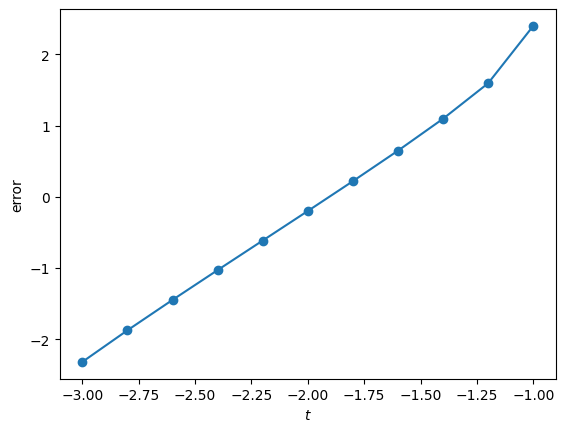

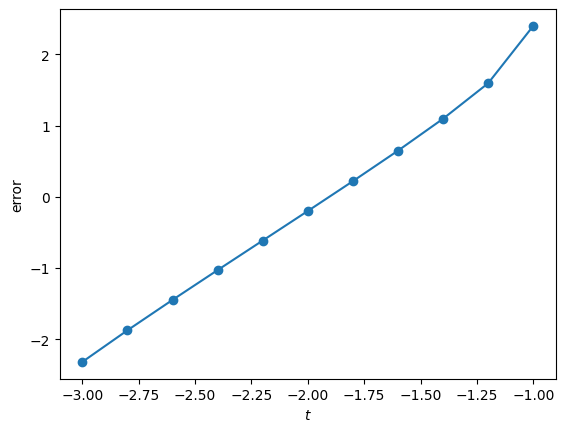

In [4]:
plt.plot(np.log10(T[0:9]),np.log10(delta1[0:9]),'-o')
plt.xlabel('$t$')
plt.ylabel('error')
plt.savefig(output+'/delta1.png')

plt.figure()
plt.plot(np.log10(T[0:9]),np.log10(delta2[0:9]),'-o')
plt.xlabel('$t$')
plt.ylabel('error')
plt.savefig(output+'/delta2.png')

In [3]:
from sklearn.linear_model import LinearRegression

X = np.log10(T[0:9]).reshape(-1, 1) 
y = np.log10(delta1[0:9])
reg = LinearRegression().fit(X, y)
order1 = reg.coef_[0]
print(f"order surface = {order1}")

X = np.log10(T[0:9]).reshape(-1, 1) 
y = np.log10(delta2[0:9])
reg = LinearRegression().fit(X, y)
order2 = reg.coef_[0]
print(f"order volume = {order2}")

order surface = 2.1158602786490257
order volume = 2.1158605061232887
